In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os

def getResults(path, msgsPerFile):
    folders = os.listdir(path)
    df  = pd.DataFrame()
    for folder in folders:
        dct = {} 
        par = folder.split('_')
        dct['nodes'] = int(par[0])
        dct['port'] = int(par[1])
        dct['time'] = int(par[2])
        dct['execMem'] = par[3]
        dct['batchDur'] = int(par[4])
        if par[5]=='':
            dct['version'] = 0
        else:
            dct['version'] = int(par[5])

        with open(path+folder+'/logSpark.txt','r') as f:
            line = f.readline()
            while line:
                if line.startswith('Number of messages: '):
                    dct['recvMsgs'] = int(line.lstrip('Number of messages: ').strip())
                if line.startswith('Total update time: '):
                    dct['updateTime'] = int(line.lstrip('Total update time: ').strip())
                if line.startswith('Size of the data: '):
                    dct['totalSize'] = int(line.lstrip('Size of the data: ').strip())

                line = f.readline()
        dct['sentMsgs'] = getProcessingResults(path+folder)['messagesSent'].iloc[-1]

#         with open(path+folder+'/producerResult.txt','r') as f:
#             line = f.readline()
#             dct['sentMsgs'] = 0
#             while line:
#                 dct['sentMsgs']+=int(line.split(' ')[4])*msgsPerFile
#                 line = f.readline()

        df2 = pd.DataFrame([dct], columns=dct.keys())
        df = pd.concat([df, df2], axis=0)
    return df


In [76]:
def getProcessingResults(path):

    numMsgsProcessed = []
    timestamp = []
    with open(path+'/logSpark.txt','r') as f:
        line = f.readline()
        while line:
            if line.startswith('Time elapsed '):
                numMsgsProcessed.append(int(line.split(' ')[5]))
                timestamp.append(datetime.fromtimestamp(int(line.split(' ')[2])/1000.0))
            line = f.readline()

    dfSpark = pd.DataFrame({'time':timestamp, 'messagesProcessed': numMsgsProcessed})

    numMsgsSent = []
    timestamp = []
    portMap = {}
    portData = []

    with open(path+'/producerResult.txt','r') as f:
        line = f.readline()
        while line:
            # check if the port on the 
            port = line.split(' ')[7]
            if port not in portMap.keys():
                portMap[port] = len(portMap)
                portData.append([])
                portData[portMap[port]] = [None]*2
                portData[portMap[port]][0] = []
                portData[portMap[port]][1] = []
            index = portMap[port]

            portData[index][1].append(int(line.split(' ')[4]))
            portData[index][0].append(datetime.fromtimestamp(float(line.split(' ')[0])/1000.0))
            line = f.readline()

    df = []
    for i in portData:
        df.append(pd.DataFrame({'time':i[0],'messagesSent':i[1]}))

    dfConcat = df[0]
    for i in range(1, len(df)):
        dfConcat = pd.merge_ordered(dfConcat,df[i],on='time',fill_method='ffill').fillna(0)
        dfConcat['Sum'] = dfConcat['messagesSent_x']+dfConcat['messagesSent_y']
        dfConcat = dfConcat.drop(columns=['messagesSent_x','messagesSent_y'])
        dfConcat = dfConcat.rename(columns={'Sum':'messagesSent'})

    dfProducer = dfConcat

    dfConcat = pd.merge_ordered(dfSpark, dfProducer, on='time', fill_method='ffill').fillna(0)

    return dfConcat

In [2]:
def getMonitorData(path, VM):
    dct = {}
    dct['producer'] = 'log_producer.csv'
    dct['master'] = 'log_master.csv'
    dct['slave1'] = 'log_slave1.csv'
    dct['slave2'] = 'log_slave2.csv'
    dct['slave3'] = 'log_slave3.csv'
    dct['slave4'] = 'log_slave4.csv'
    dct['slave5'] = 'log_slave5.csv'
    dct['slave6'] = 'log_slave6.csv'
    # Start and Stop times for Spark Application
    with open(path+'/logSpark.txt','r') as f:
        line = f.readline()
        while line:
            if line.startswith('Application started at: '):
                startTime = datetime.strptime(line.strip('Application started at: ').rstrip(),'%H:%M:%S.%f').time()            
            if line.startswith('Application stopped at: '):
                stopTime = datetime.strptime(line.strip('Application stopped at: ').rstrip(),'%H:%M:%S.%f').time()
                break
            line = f.readline()
    
    with open(path+'/'+dct[VM],'r') as f:
        line = f.readline()
        timestamp = []
        cpu = []
        mem = []
        read_count = []
        write_count = []
        read_bytes = []
        write_bytes = []
        read_time = []
        write_time = []
        bytes_sent = []
        lo_bytes_sent = []
        lo_bytes_recv = []
        lo_packets_sent = []
        lo_packets_recv = []
        lo_errin = []
        lo_errout = []
        lo_dropin = []
        lo_dropout = []
        ens3_bytes_sent = []
        ens3_bytes_recv = []
        ens3_packets_sent = []
        ens3_packets_recv = []
        ens3_errin = []
        ens3_errout = []
        ens3_dropin = []
        ens3_dropout = []
        while line:
            words = line.split(",")
            timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
            cpu.append(float(words[1]))
            mem.append(float(words[2]))        
            read_count.append(int(words[3]))         
            write_count.append(int(words[4]))
            read_bytes.append(int(words[5]))
            write_bytes.append(int(words[6]))
            read_time.append(int(words[7]))
            write_time.append(int(words[8]))
            lo_bytes_sent.append(int(words[9]))
            lo_bytes_recv.append(int(words[10]))
            lo_packets_sent.append(int(words[11]))
            lo_packets_recv.append(int(words[12]))
            lo_errin.append(int(words[13]))
            lo_errout.append(int(words[14]))
            lo_dropin.append(int(words[15]))
            lo_dropout.append(int(words[16]))
            ens3_bytes_sent.append(int(words[17]))
            ens3_bytes_recv.append(int(words[18]))
            ens3_packets_sent.append(int(words[19]))
            ens3_packets_recv.append(int(words[20]))
            ens3_errin.append(int(words[21]))
            ens3_errout.append(int(words[22]))
            ens3_dropin.append(int(words[23]))
            ens3_dropout.append(int(words[24]))
            line = f.readline()

        for i in range(len(timestamp)):
            if timestamp[i] < startTime:
                start = i+1
            if timestamp[i] > stopTime:
                end = i-1
                break
        df = pd.DataFrame({'time':timestamp[start:end+1],'cpu':cpu[start:end+1], 'mem':mem[start:end+1],
                          'read_count': [read_count[i]-read_count[i-1] for i in range(start,end+1)], 
                           'write_count': [write_count[i]-write_count[i-1] for i in range(start, end+1)],
                          'read_bytes':[read_bytes[i]-read_bytes[i-1] for i in range(start, end+1)],
                          'write_bytes':[write_bytes[i]-write_bytes[i-1] for i in range(start, end+1)],
                           'read_time': [read_time[i]-read_time[i-1] for i in range(start, end+1)],
                           'write_time': [write_time[i]-write_time[i-1] for i in range(start, end+1)],
                           'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(start, end+1)]
                          })
        
        return df


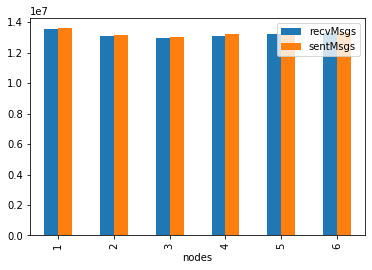

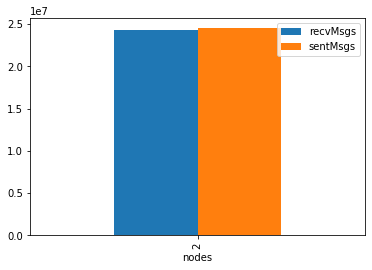

In [88]:
path = './results/'
msgsPerFile = 1

df = getResults(path, msgsPerFile)

# df1 = df[(df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

### Do more nodes mean more messages processed?

# 1 port 
df1 = df[(df['port']==1) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

# 2 ports
df1 = df[(df['port']==2) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

# # 3 ports
# df1 = df[(df['port']==3) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 3 ports
# df1 = df[(df['port']==3) & (df['execMem']=='4g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 3 ports
# df1 = df[(df['port']==3) & (df['execMem']=='8g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 3 ports
# df1 = df[(df['port']==3) & (df['execMem']=='12g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 3 ports
# df1 = df[(df['port']==3) & (df['execMem']=='14g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 4 ports
# df1 = df[(df['port']==4) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 4 ports
# df1 = df[(df['port']==4) & (df['execMem']=='4g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 4 ports
# df1 = df[(df['port']==4) & (df['execMem']=='8g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 4 ports
# df1 = df[(df['port']==4) & (df['execMem']=='12g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 4 ports
# df1 = df[(df['port']==4) & (df['execMem']=='14g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 5 ports
# df1 = df[(df['port']==5) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

# # 6 ports
# df1 = df[(df['port']==6) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
# df1.plot.bar(x='nodes')

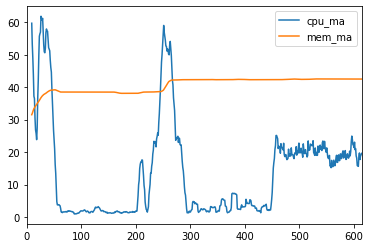

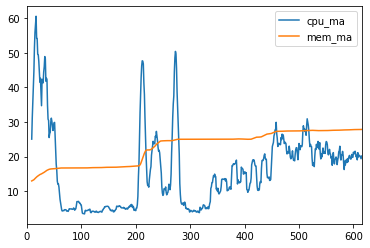

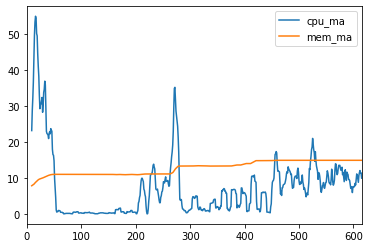

In [59]:
# pick a folder
path = 'results/6_4_300000_2g_1_'

df = getMonitorData(path, 'master')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])

df = getMonitorData(path, 'slave5')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])

df = getMonitorData(path, 'slave6')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])

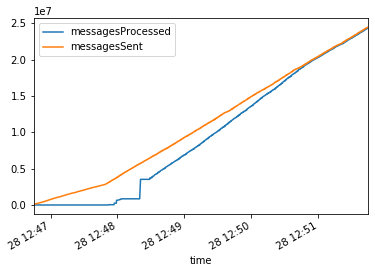

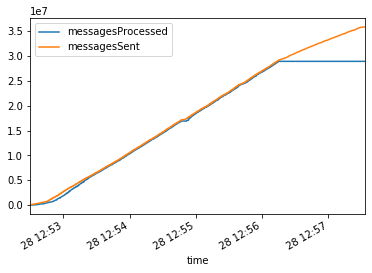

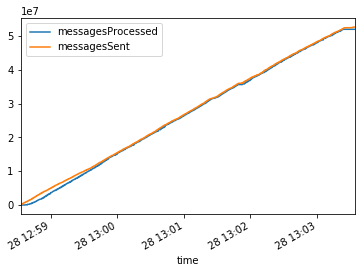

In [91]:
path = 'results/2_2_300000_2g_1_'

getProcessingResults(path).plot(x='time')

path = 'results/3_3_300000_2g_1_'

getProcessingResults(path).plot(x='time')

path = 'results/4_4_300000_2g_1_'

getProcessingResults(path).plot(x='time')

